In [ ]:
!brew install libomp
%pip install seaborn

%pip install kagglehub
%pip install --upgrade category_encoders
%pip uninstall -y xgboost
%pip install xgboost
%pip install lightgbm
%pip install shap

# Predicción de diabetes

Importamos librerías

In [287]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [288]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Importamos el set de datos

Traemos el set de datos e iniciamos el análisis de estos.

In [289]:
# Importar set de datos
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [290]:
# Descipción de datos
print(df.describe())
print(df.shape)
print(df.info())

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

### Análisis de datos
Revisamos la distribución de los datos, empezando por el género

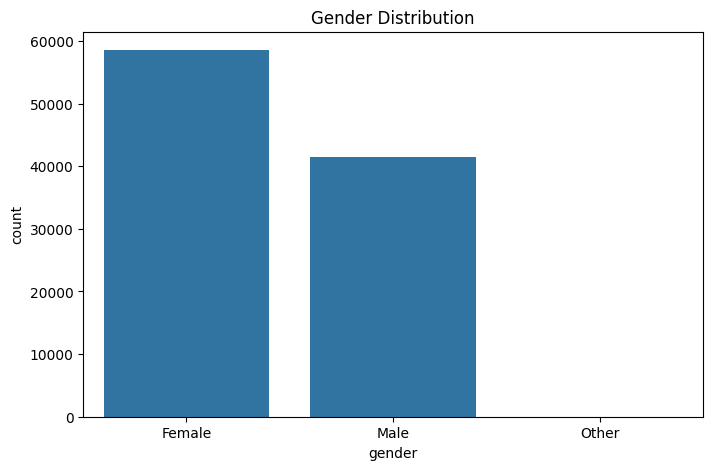

In [291]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gender')
plt.title("Gender Distribution")
plt.show()

In [292]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [293]:
# Descartamos la categoría 'Other' del género
df = df[df['gender'] != 'Other']
# Revisamos de nuevo la distribución de género
df["gender"].value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [294]:
# Convertimos género Hombre, Mujer, a 1, 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [295]:
# Validamos si tenemos valores vacíos
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

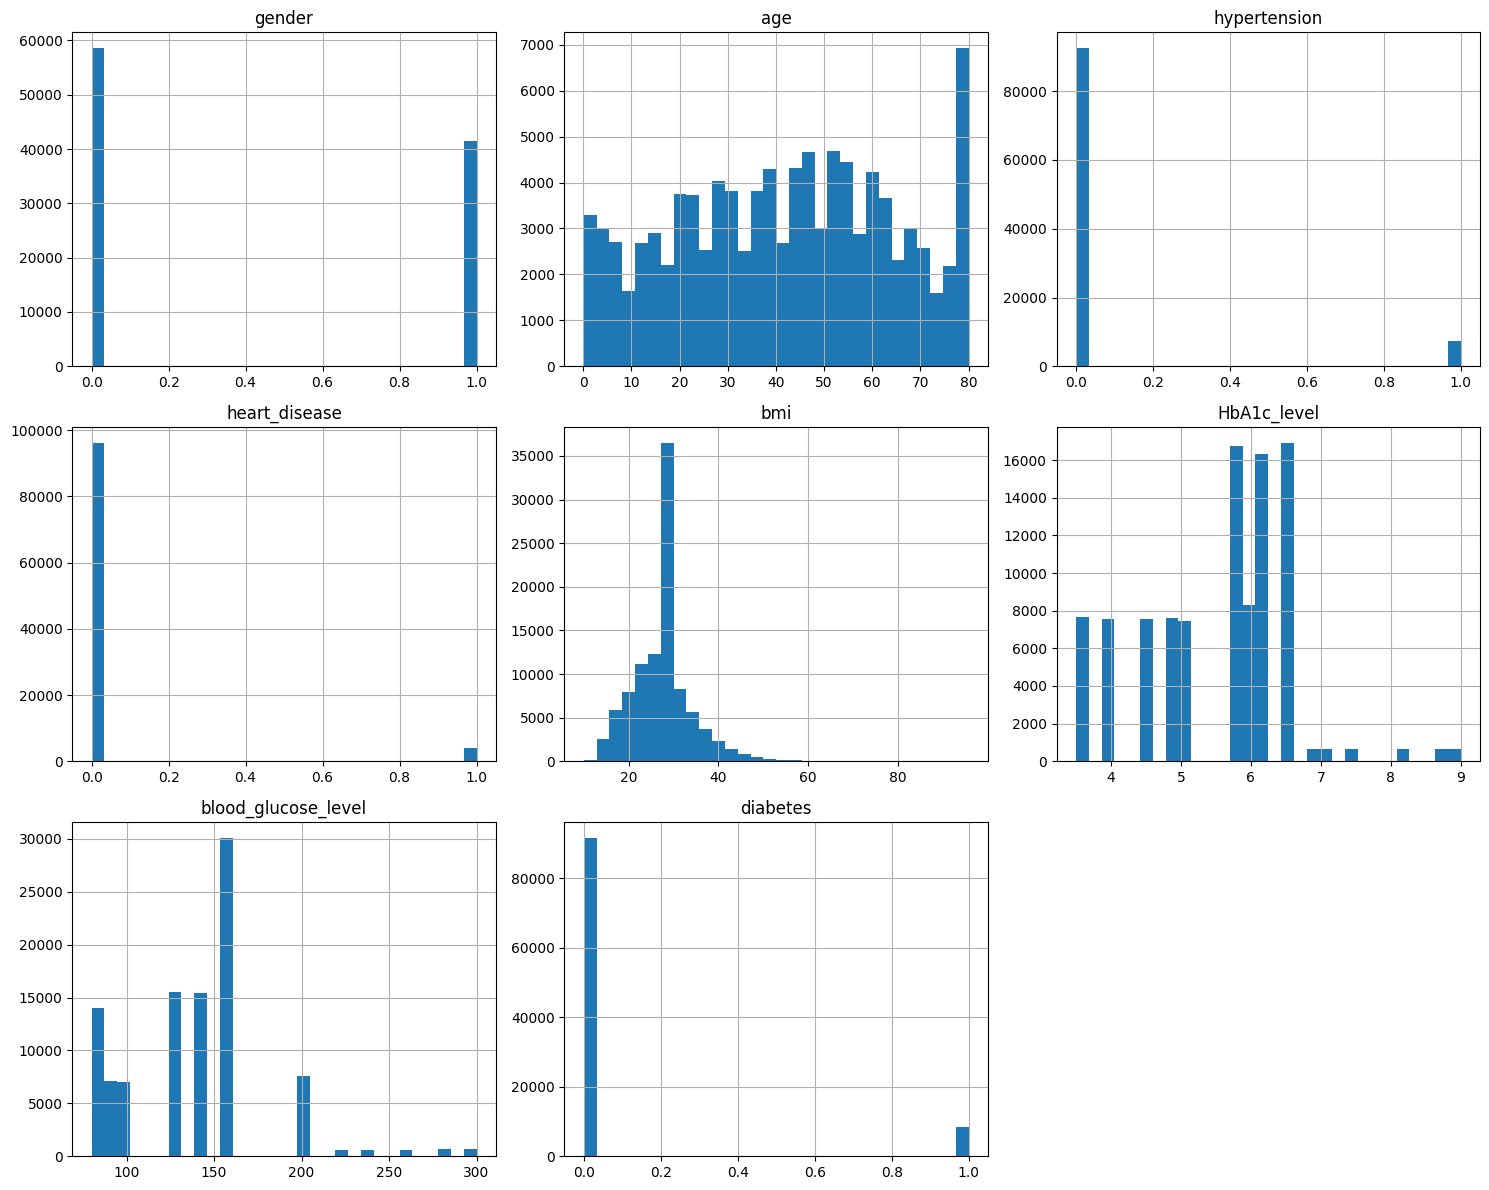

In [296]:
# Revisamos la distribución de las variables
df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

### Revisamos la incidencia de nuestra variable objetivo

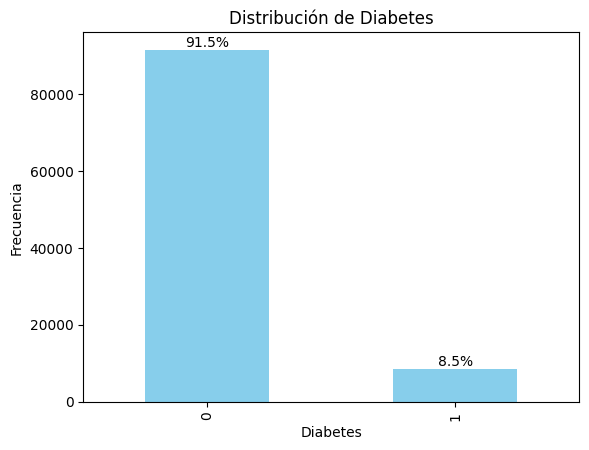

In [297]:
# Variable objetivo: Diabetes

# Calculamos la incidencia y su porcentaje respecto a la muestra
value_counts = df['diabetes'].value_counts()
percentages = (value_counts / len(df) * 100).round(2)

# Creamos un gráfico de barras para visualizar la distribución
ax = value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frecuencia')

# Asignamos al gráfico los porcentajes
for i, count in enumerate(value_counts):
    percentage = percentages[i]
    ax.text(i, count + 1, f'{percentage}%', ha='center', va='bottom', fontsize=10)

plt.show()

In [298]:
# Revisamos los valores posibles de la variable smoking_history
unique_values = df['smoking_history'].unique()

In [299]:
# Convertimos el historial de fumador a 1, 0
# En la muestra, todos los que en algún momento han fumado son considerados fumadores
# y los que nunca han fumado son considerados no fumadores
df['smoking_history'] = df['smoking_history'].map({
    'No Info': 0,
    'never': 0,
    'former': 1,
    'current': 1,
    'not current': 1,
    'ever': 1
})

Generando gráficos de conteo...


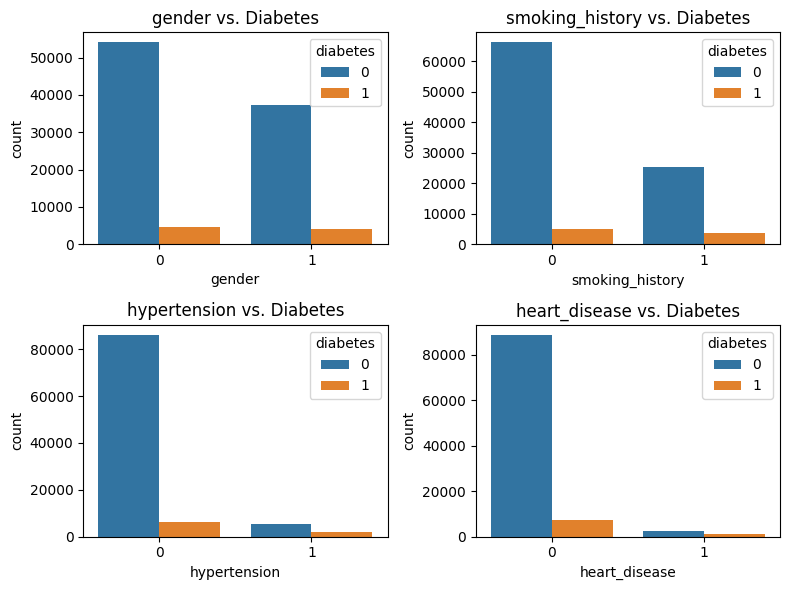

In [300]:
print("Generando gráficos de conteo...")
categorical_cols = ['gender', 'smoking_history', 'hypertension', 'heart_disease']

# Primera figura con los primeros 4 gráficos
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 6))
axes1 = axes1.flatten()  # Aplanar para facilitar el indexado

for i in range(min(4, len(categorical_cols))):
    sns.countplot(x=categorical_cols[i], hue='diabetes', data=df, ax=axes1[i])
    axes1[i].set_title(f'{categorical_cols[i]} vs. Diabetes')

plt.tight_layout()
plt.show()

# Segunda figura con los gráficos restantes
if len(categorical_cols) > 4:
    fig2, axes2 = plt.subplots(1, len(categorical_cols)-4, figsize=(8, 6))
    if len(categorical_cols) == 5:  # Manejar el caso de un único subplot
        axes2 = [axes2]
        
    for i in range(4, len(categorical_cols)):
        sns.countplot(x=categorical_cols[i], hue='diabetes', data=df, ax=axes2[i-4])
        axes2[i-4].set_title(f'{categorical_cols[i]} vs. Diabetes')
    
    plt.tight_layout()
    plt.show()

In [301]:
# Mostrar duplicados
df.duplicated().sum()
# Drop duplicates
df = df.drop_duplicates()
# Check again
df.duplicated().sum()

np.int64(0)

In [302]:
# Revisar el tamaño del DataFrame
df.shape

(93718, 9)

In [ ]:
# Revisar 10 muestras aleatorias
df.sample(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
98758,0,28.0,0,0,0,28.39,6.0,155,0
96871,0,55.0,0,0,0,27.32,5.8,200,0
53809,1,40.0,0,0,0,27.88,6.1,140,1
65152,1,27.0,0,0,0,27.32,4.8,200,0
70866,1,35.0,0,0,0,34.14,5.7,90,0
87517,0,42.0,0,0,0,58.56,6.0,126,0
80126,0,80.0,0,0,0,26.10,4.0,140,0
45849,0,70.0,0,0,0,27.32,6.0,155,0
95142,0,54.0,0,0,1,21.96,4.0,160,0
90269,1,57.0,0,0,1,27.32,3.5,130,0


### Regresión logística

In [304]:
# Ingeniería de características, incluir nuevas características a partir de las existentes
df['bmi_age_ratio'] = df['bmi'] / df['age']
df['glucose_hba1c_ratio'] = df['blood_glucose_level'] / df['HbA1c_level']

In [305]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'bmi_age_ratio', 'glucose_hba1c_ratio']
binary_features = ['smoking_history', 'hypertension', 'heart_disease', 'gender']

# Crear el pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Crear el pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Dividir los datos
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar y transformar los datos
pipeline.fit(X_train, y_train)

# Obtener los nombres de las características después de la transformación
feature_names = numeric_features + binary_features

print("Feature names after transformation:")
print(feature_names) 

Feature names after transformation:
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'bmi_age_ratio', 'glucose_hba1c_ratio', 'smoking_history', 'hypertension', 'heart_disease', 'gender']



Métricas del modelo de Regresión Logística:
MAE (Error Absoluto Medio): 0.0412
R² (Coeficiente de Determinación): 0.4993

Matriz de Confusión:


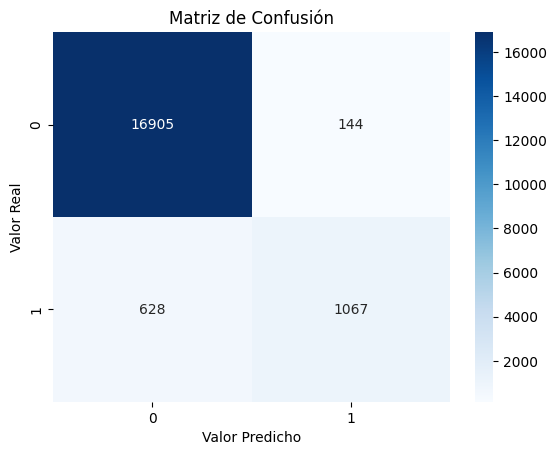


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.88      0.63      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.86     18744
weighted avg       0.96      0.96      0.96     18744



In [306]:
# Hacer predicciones
y_pred = pipeline.predict(X_test)

# Calcular métricas

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas del modelo de Regresión Logística:")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

# También podemos ver la matriz de confusión para entender mejor el rendimiento

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Random forest

In [307]:
# Creamos un nuevo pipeline para el modelo de Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}
# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
# Fit the Random Forest model
rf.fit(X_train, y_train)
print(rf.best_params_)

{'regressor__max_depth': 9, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 100}


Train set
Model: Random Forest
R^2: 0.709001549056824
MAE: 0.04857184472068897


Test set
Model: Random Forest
R^2: 0.7032832674679301
MAE: 0.04939489790736105



Matriz de Confusión:


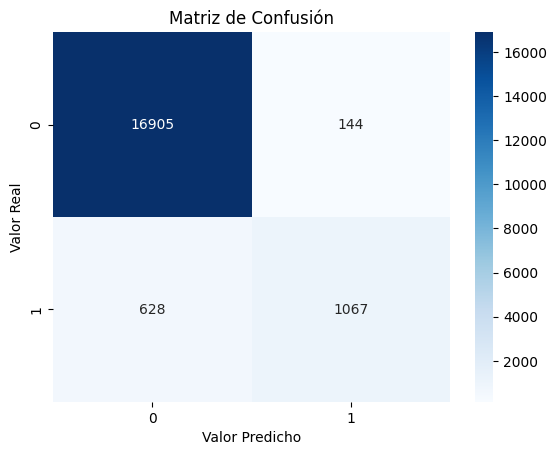


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.88      0.63      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.86     18744
weighted avg       0.96      0.96      0.96     18744



In [308]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
print(f"Model: {'Random Forest'}")
print(f'R^2: {rf.score(X_train, y_train)}')
print(f'MAE: {mean_absolute_error(y_train, rf.predict(X_train))}')
print('\n')

print("Test set")
print(f"Model: {'Random Forest'}")
print(f'R^2: {rf.score(X_test, y_test)}')
print(f'MAE: {mean_absolute_error(y_test, rf.predict(X_test))}')
print('\n')

# También podemos ver la matriz de confusión para entender mejor el rendimiento
# Make predictions
y_pred_rf = pipeline.predict(X_test)

print("\nMatriz de Confusión:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Gradient boosting

In [309]:
# Creamos un nuevo pipeline para el modelo de Gradient Boosting
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}
# Definamos nuestros modelo mediante GridSearchCV:
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)
# Fit the Gradient Boosting model
gb.fit(X_train, y_train)
print(gb.best_params_)

{'regressor__max_depth': 7, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}


Train set
Model: Gradient Boosting
R^2: 0.7189668952498605
MAE: 0.04889846595209244


Test set
Model: Gradient Boosting
R^2: 0.7082640128195797
MAE: 0.05013855106870269



Matriz de Confusión:


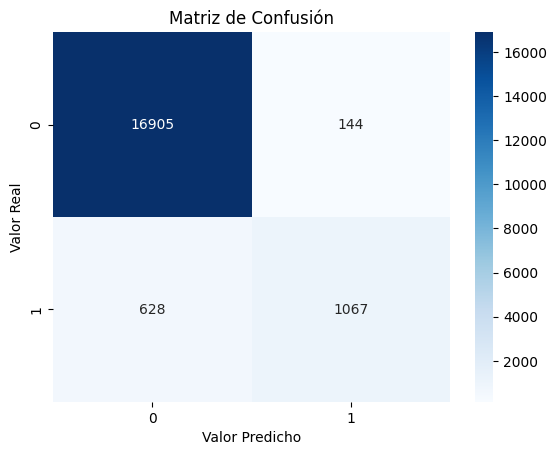


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.88      0.63      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.86     18744
weighted avg       0.96      0.96      0.96     18744



In [310]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
print(f"Model: {'Gradient Boosting'}")
print(f'R^2: {gb.score(X_train, y_train)}')
print(f'MAE: {mean_absolute_error(y_train, gb.predict(X_train))}')
print('\n')

print("Test set")
print(f"Model: {'Gradient Boosting'}")
print(f'R^2: {gb.score(X_test, y_test)}')
print(f'MAE: {mean_absolute_error(y_test, gb.predict(X_test))}')
print('\n')

# También podemos ver la matriz de confusión para entender mejor el rendimiento
# Make predictions
y_pred_gb = pipeline.predict(X_test)

print("\nMatriz de Confusión:")
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### Explicabilidad
Usaremos Shap

In [311]:
import shap
from IPython.display import HTML

/Users/damtrax/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [312]:
#Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'HbA1c_level',
                                                   'blood_glucose_level',
                                                   'bmi_age_ratio',
                                                   'glucose_hba1c_ratio']),
                                                 ('binary', 'passthrough',
                                                  ['smoking_history',
                                                   'hypertension',
                                                   'heart_disease',
                                                   'gender'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=7, min_samples_leaf=10,
                                           n_estimators=50, random_state=42))])

In [313]:
# Calculamos el valor esperado de la predicción
y_est = pipeline_gb.predict(X_train)
Efx = np.mean(y_est) 

In [314]:
Efx

np.float64(0.09024461813428654)

In [315]:
# Validamos la influencia de cada variable en la predicción del modelo
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps["regressor"])
train_gb_shap_values = gb_explainer.shap_values(X_train)

In [316]:
val = train_gb_shap_values.sum(axis=1)
print(val)

[0.26285693 0.26285693 0.20520467 ... 0.42730718 0.26285693 0.26285693]


In [317]:
fx = Efx + val
print(fx)

[0.35310155 0.35310155 0.29544929 ... 0.5175518  0.35310155 0.35310155]


In [318]:
y_est

array([ 0.02355041,  0.12661796, -0.00417699, ...,  0.00062793,
       -0.00280659,  0.05006453], shape=(74974,))

In [319]:
train_gb_shap_values[1].shape

(10,)

In [320]:
# Revisamos la contribución de cada característica a la predicción
# Nos aseguramos de que mantenemos las dimensiones del conjunto de datos
test_gb_shap_values = gb_explainer.shap_values(X_test)
test_gb_shap_values[1].shape

(10,)

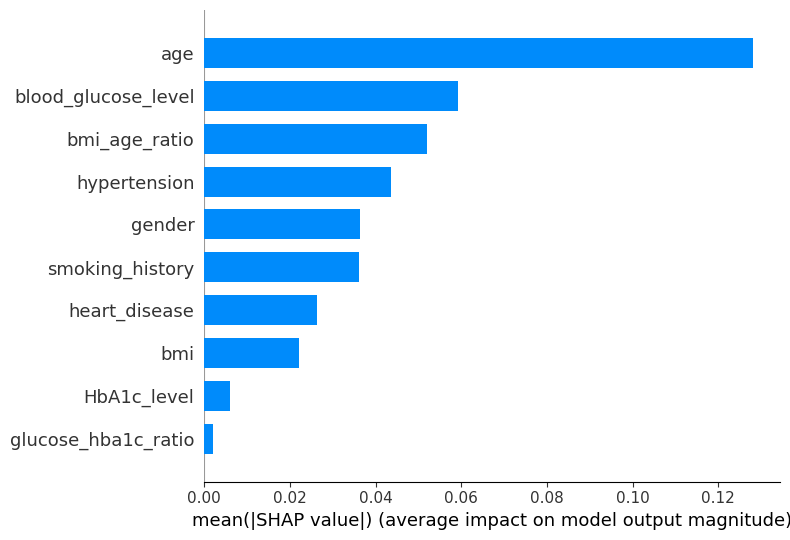

In [321]:
# Imprimimos un resumen de las características
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar")

In [322]:
# Creamos un gráfico de fuerza para ina instancia del conjunto de datos
# Ayuda a cómo el modelo toma decisiones y cómo cada característica influye en la predicción
shap.initjs()

instance_index = 0
force_plot_html = shap.force_plot(gb_explainer.expected_value, test_gb_shap_values[instance_index], X_test.iloc[instance_index],show=False)
HTML(force_plot_html.html())

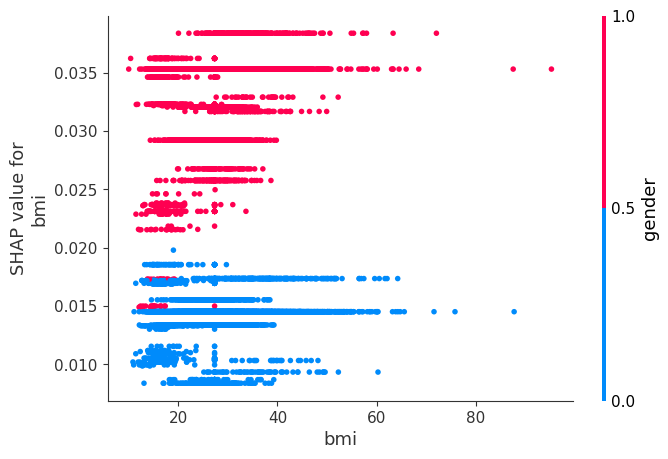

In [323]:
#Dependence plot
shap.dependence_plot('bmi', test_gb_shap_values, X_test)

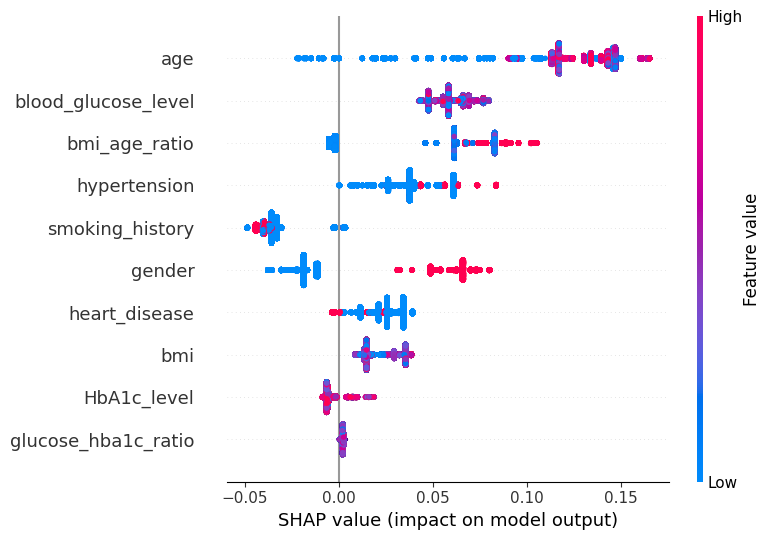

In [324]:
#Summary plot
shap.summary_plot(train_gb_shap_values, X_train)